In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from ase.io import write, read
import pandas as pd
import umap
import seaborn as sns
from quippy.descriptors import Descriptor
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

plt.style.use('~/plot.mplstyle')
mpl.rcParams['mathtext.default']='regular'

In [13]:
def cycle_colors(n):
    colors = ['#332288', '#117733', '#44AA99', 
               '#88CCEE', '#DDCC77', '#CC6677',
               '#AA4499', '#882255', '#981558', '#D83B3B']
    return colors[n % len(colors)]

def cycle_markers(n):
    markers = ['o', '^', 'v', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd',]
    return markers[n % len(markers)]

def umap_config(row):
    config=row["config"]
    if config=='cbulk' or config=='SnB':
        umap_config='crystalline'
    elif config=='amorph' or config=='ahighT':
        umap_config='amorphous'
    elif config=='cluster' or config=='sp':
        umap_config='random cluster'
    elif config=='metabulk' or config=='high-p':
        umap_config='high-p'
    elif config=='a-surface' or config=='c-surface':
        umap_config='surface'
    elif config=='liq':
        umap_config='liquid'
    elif config=='mol':
        umap_config='molecule'
    else:
        print(config)
    return umap_config

In [14]:
def structure_soap(atoms):
    soap_descriptor_str = ('soap l_max=6 n_max=8 ' # basis function size
                       'atom_sigma=0.5 cutoff=5 ' # smoothness and cutoff (Angstrom) 
                       'average=T') # average descriptor over whole cell, or one descriptor for each atom
    soap_cell_average = Descriptor(soap_descriptor_str)

    average_descriptor = soap_cell_average.calc_descriptor(atoms)
    average_descriptor = np.array(average_descriptor).squeeze() 

    return average_descriptor

In [6]:
file_train='../../data/datasets/combined-to-Ite6-filtered-Fmag-50-Emax-0-min-Si-1.6-SiH-1.0-train.pkl.gzip'
df=pd.read_pickle(file_train, compression='gzip')
df['Hconc']=df["nH"]/df['nb_atoms']
df['umap_config']=df.apply(umap_config, axis=1)

In [7]:
# SOAPs for Ite0 only
df_ite0=df[df.iteration==0]
frames_ite0=df_ite0['ase_atoms'].values.tolist()

soaps_ite0=np.zeros(shape=(len(frames_ite0), 253))

for i in range(len(frames_ite0)):
    atoms=frames_ite0[i]
    soaps_ite0[i,:]=structure_soap(atoms)


# SOAPs for all ites
frames=df['ase_atoms'].values.tolist()
soaps=np.zeros(shape=(len(frames), 253))

for i in range(len(frames)):
    atoms=frames[i]
    # atoms.arrays.pop('labels')
    # print(len(structure_soap(atoms)))
    soaps[i,:]=structure_soap(atoms)

In [8]:
trans = umap.UMAP(n_neighbors=500, min_dist=1, random_state=42).fit(soaps_ite0)
u=trans.transform(soaps)
df['umap_1']=u[:, 0]
df['umap_2']=u[:, 1]

/Users/louiserosset/software/miniconda3/envs/acenv-25/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
selec_stru_v2=np.asarray([3939, 3688, 4793, 1018,4815,4824, 4145,4930,4436])-1


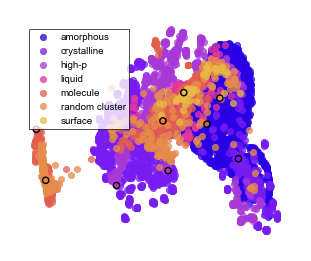

In [10]:
fig,ax = plt.subplots(figsize=(3,2.5),constrained_layout=True)
colors=["#2a00e6","#791cf4","#a839d8","#e43799","#e25f4e","#e68d4a","#e9bb45"]

dfs = [data for g,data in df.groupby(by="umap_config")]

for ii,df_tmp in enumerate(dfs[::1]):
    label = df_tmp.iloc[0]["umap_config"]
    color=colors[ii]
    marker = 'o'
    
    ax.scatter(df_tmp["umap_1"],
            df_tmp["umap_2"],
            label=label,
            marker=marker,
            c=color,
            alpha=0.75,
            s=20,
            rasterized=True)

ax.set_axis_off()
ax.legend()
selec = df.iloc[selec_stru_v2]
ax.scatter(selec['umap_1'], selec['umap_2'], marker='o', s=20, facecolors='none', edgecolors='black', linewidth=1)

/var/folders/z4/v8cnfld964b8x3vqdvtc45pr0000gr/T/ipykernel_3459/3792038450.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


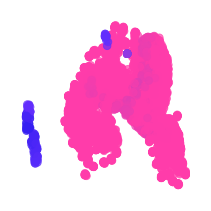

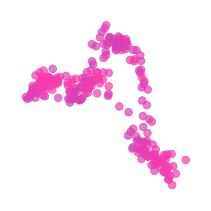

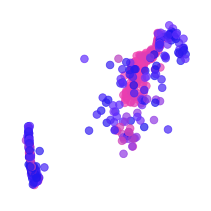

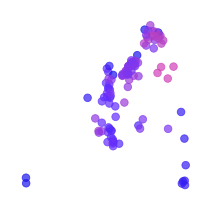

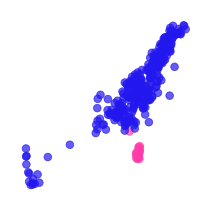

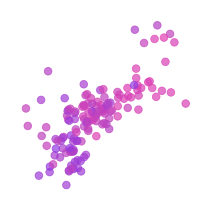

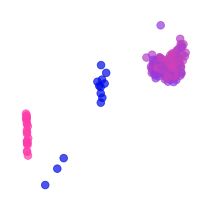

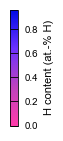

In [16]:
# Define the RGB colors for the gradient

colors_rgb = [
    mcolors.to_rgb('#FF3CAA'),  
    mcolors.to_rgb('#BE43BE'),
    mcolors.to_rgb('#6C32FF'), 
    mcolors.to_rgb('#000BE6')   
]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_hsla_gradient', colors_rgb)

vmin = df['Hconc'].min()
vmax = df['Hconc'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for i in np.arange(0, 7):
    df_ite = df[df['iteration'] == i]
    fig, ax = plt.subplots(figsize=(2, 2), constrained_layout=True)

    dfs = [data for g, data in df_ite.groupby(by="umap_config")]

    for ii, df_tmp in enumerate(dfs):
        label = df_tmp.iloc[0]["umap_config"]
        marker = cycle_markers(ii)

        # Map scalar values to colors
        color_values = df_tmp['Hconc'].values
        mapped_colors = custom_cmap(norm(color_values))

        sc = ax.scatter(df_tmp["umap_1"],
                        df_tmp["umap_2"],
                        label=label,
                        marker='o',
                        c=mapped_colors,
                        edgecolors=mapped_colors,
                        alpha=0.7,
                        s=30, rasterized=True)

    ax.set_axis_off()
    fig.savefig(f'ite{i}.svg', dpi=300)


# Colorbar
fig, ax = plt.subplots(figsize=(0.25, 1.5))
fig.subplots_adjust(left=0.3, right=0.6) 

sm = cm.ScalarMappable(norm=norm, cmap=custom_cmap)
sm.set_array([])  # Dummy array for ScalarMappable
cbar = fig.colorbar(sm, cax=ax)
cbar.set_label('H content (at.-% H)')
fig.tight_layout()

fig.savefig(f'cmap.svg', dpi=300)